In [2]:
from spice.models.binary import Binary, add_orbit
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import jax.numpy as jnp
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [3]:
def default_icosphere(radius=1):
    return get_mesh_view(IcosphereModel.construct(100, radius, 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_47830/1572789170.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', num_tris)


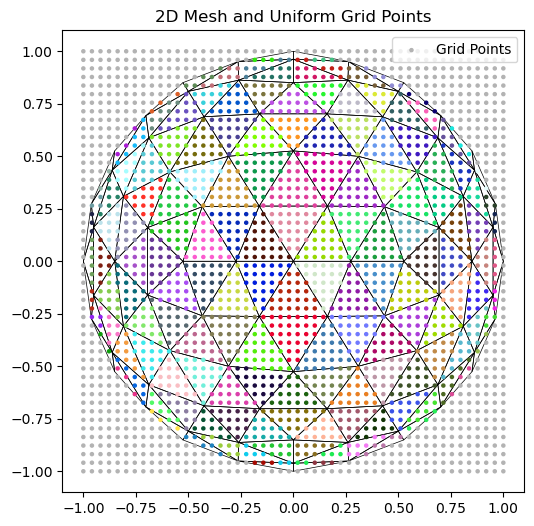

In [4]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.cm as cm

# Get the 2D projected vertices
verts2d = body1.cast_vertices  # shape (n_vertices, 2)

import jax
import jax.numpy as jnp

@jax.jit
def point_in_triangle(pt, tri_verts):  # tri_verts: (3,2)
    a, b, c = tri_verts[0], tri_verts[1], tri_verts[2]
    v0 = c - a
    v1 = b - a
    v2 = pt - a
    dot00 = jnp.dot(v0, v0)
    dot01 = jnp.dot(v0, v1)
    dot02 = jnp.dot(v0, v2)
    dot11 = jnp.dot(v1, v1)
    dot12 = jnp.dot(v1, v2)
    denom = dot00 * dot11 - dot01 * dot01
    denom = jnp.where(denom == 0.0, jnp.finfo(tri_verts.dtype).eps, denom)
    u = (dot11 * dot02 - dot01 * dot12) / denom
    v = (dot00 * dot12 - dot01 * dot02) / denom
    return (u >= 0) & (v >= 0) & (u + v <= 1)

@jax.jit
def construct_triangle_to_gridpts(mesh, n_grid: int = 50):
    # DO NOT boolean-index with mesh.mus inside jit
    faces   = jnp.asarray(mesh.faces).astype(jnp.int32)        # (T, 3)
    visible = (jnp.asarray(mesh.mus) > 0)                      # (T,)
    verts2d = jnp.asarray(mesh.cast_vertices).astype(jnp.float32)  # (V, 2)

    # Grid over bounds
    x_min, y_min = jnp.min(verts2d, axis=0)
    x_max, y_max = jnp.max(verts2d, axis=0)
    x_grid = jnp.linspace(x_min, x_max, n_grid)
    y_grid = jnp.linspace(y_min, y_max, n_grid)
    xx, yy = jnp.meshgrid(x_grid, y_grid, indexing="xy")
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)   # (P, 2)

    # Triangle vertices for all faces
    tri_verts = verts2d[faces]  # (T, 3, 2)

    # Vectorized point-in-triangle for ALL faces, then mask by 'visible'
    vmap_pt  = jax.vmap(lambda pt, tri: point_in_triangle(pt, tri), in_axes=(0, None))
    vmap_tri = jax.vmap(lambda tri: vmap_pt(grid_points, tri),      in_axes=(0,))
    mask_TP  = vmap_tri(tri_verts)                                  # (T, P)
    mask_TP  = jnp.where(visible[:, None], mask_TP, False)          # zero-out invisible faces

    # For each grid point pick the first visible triangle (or -1)
    first_true = jnp.argmax(mask_TP, axis=0)            # (P,)
    any_true   = jnp.any(mask_TP, axis=0)               # (P,)
    grid_tri_indices = jnp.where(any_true, first_true, -1).astype(jnp.int32)

    return mask_TP, grid_tri_indices, grid_points

triangle_to_gridpts, grid_tri_indices, grid_points = construct_triangle_to_gridpts(body1)

faces = body1.faces[body1.mus > 0].astype(int)
verts2d = body1.cast_vertices

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the 2D mesh (projected vertices and faces)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5)
ax.add_collection(mesh)

# Assign a color to each triangle index (use a colormap)
num_tris = len(body1.faces)
cmap = cm.get_cmap('nipy_spectral', num_tris)

# Assign random color to each triangle's points
rng = np.random.default_rng(42)
random_colors = rng.random((num_tris, 4))
random_colors[:, 3] = 1.0  # set alpha to 1 for all

colors = np.empty((len(grid_points), 4))
outside_color = np.array([0.7, 0.7, 0.7, 0.5])
inside_mask = grid_tri_indices != -1

if np.any(inside_mask):
    colors[inside_mask] = random_colors[grid_tri_indices[inside_mask]]
colors[~inside_mask] = outside_color

sc = ax.scatter(
    grid_points[:, 0], grid_points[:, 1],
    s=5, c=colors, alpha=1., label='Grid Points'
)

ax.set_aspect('equal')
ax.set_title('2D Mesh and Uniform Grid Points')
ax.legend()
plt.show()


In [5]:
from matplotlib.patches import Circle

@jax.jit
def construct_points_in_circles(grid_points, circle_radius=0.25):
    # grid_points: (N, 2)
    centers = grid_points[:, None, :]   # (N, 1, 2)
    pts     = grid_points[None, :, :]   # (1, N, 2)
    dists2  = jnp.sum((centers - pts) ** 2, axis=-1)  # (N, N)
    mask    = dists2 <= circle_radius**2              # (N, N) bool
    return mask

points_in_circles = construct_points_in_circles(grid_points)

@jax.jit
def find_triangle_counts(points_in_circles_mask, triangle_to_gridpts_mask):
    # triangle_to_gridpts_mask: (T, P)
    # points_in_circles_mask:   (C, P)

    # For each (t, c), check if there exists a grid point p that is in both:
    # (T, 1, P) & (1, C, P) -> (T, C, P) -> any over P -> (T, C)
    intersects_TC = jnp.any(
        triangle_to_gridpts_mask[:, None, :] & points_in_circles_mask[None, :, :],
        axis=2
    )  # bool (T, C)

    # Count triangles per circle: sum over T
    counts_C = jnp.sum(intersects_TC, axis=0).astype(jnp.int32)  # (C,)
    return counts_C

triangle_counts = find_triangle_counts(points_in_circles, triangle_to_gridpts)

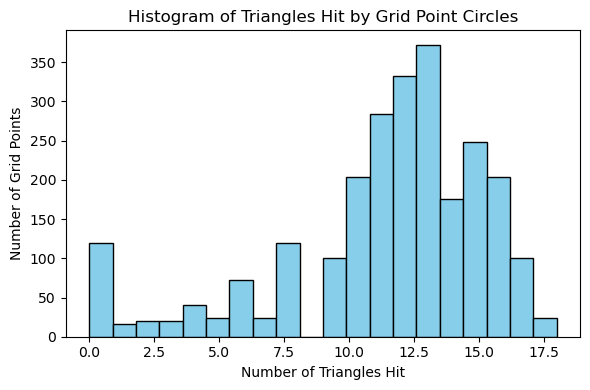

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(triangle_counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Triangles Hit')
plt.ylabel('Number of Grid Points')
plt.title('Histogram of Triangles Hit by Grid Point Circles')
plt.tight_layout()
plt.show()


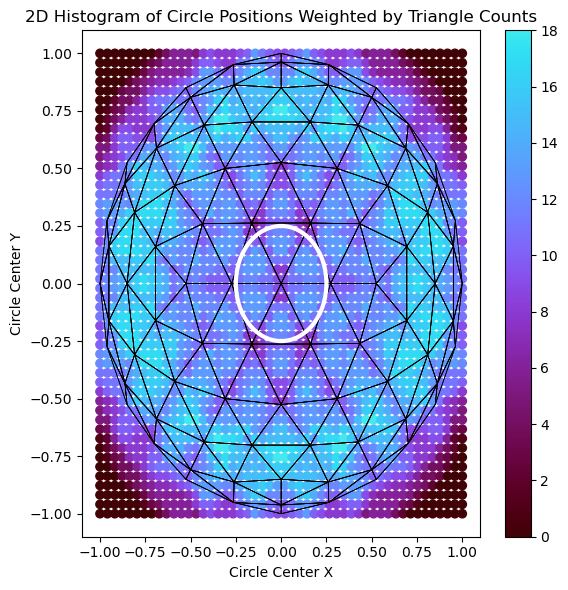

In [11]:
import matplotlib.pyplot as plt
import cmasher as cmr
x = grid_points[:, 0]
y = grid_points[:, 1]

# Use triangle_counts as the weights for each circle
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=triangle_counts, cmap='cmr.gem')
ax.set_xlabel('Circle Center X')
ax.set_ylabel('Circle Center Y')
ax.set_title('2D Histogram of Circle Positions Weighted by Triangle Counts')


verts2d = body1.cast_vertices  # shape (n_vertices, 2)
faces = body1.faces.astype(int)  # shape (n_faces, 3)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5, zorder=2)
ax.add_collection(mesh)

center = np.array([0.0, 0.0])
circle = plt.Circle(center, 0.25, color='white', fill=False, linewidth=3, zorder=3)
ax.add_patch(circle)


plt.colorbar(sc)
plt.tight_layout()
plt.show()
